=== Testing Configuration ===
Model type: ast
Dataset: gtzan
Input length: 160000
Batch size: 1

=== Loading Test Data ===
Test loader created successfully with 270 batches
---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True


/l/users/mohammed.zumri/LMGC_2/music-repro/training/models/ASTModel.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(


frequncey stride=10, time stride=10
number of patches=1212
Trainable parameters: 235680


/l/users/mohammed.zumri/LMGC_2/music-repro/training/solver.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  S = torch.load(filename)


Model loaded successfully

=== Running Inference ===


100%|██████████| 270/270 [00:27<00:00,  9.92it/s]



=== Prediction Analysis ===
Test Accuracy: 0.8926

F1-Score: 0.8913


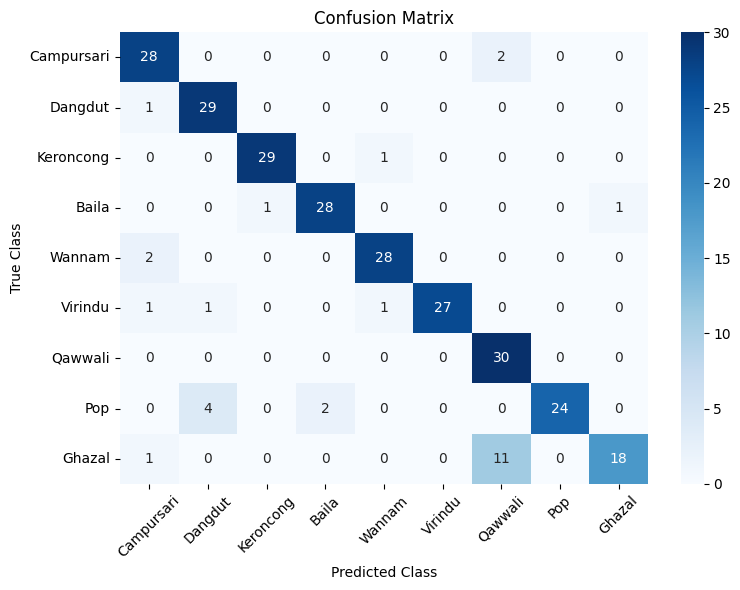


Top misclassifications:
True class 8 predicted as 6: 11 times
True class 7 predicted as 1: 4 times
True class 0 predicted as 6: 2 times
True class 4 predicted as 0: 2 times
True class 7 predicted as 3: 2 times

✅ Testing completed successfully!


In [5]:
import os
import torch
import numpy as np
import random
from solver import Solver
from data_loader.gtzan_loader import get_audio_loader
from sklearn import metrics
import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score
import torch.nn.functional as F

def fix_seed(seed):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

class Config:
    """Configuration class for testing"""
    def __init__(self):
        # Data parameters
        self.num_workers = 6
        self.dataset = "gtzan"
        self.batch_size = 1
        self.input_length = 160000
        self.data_path = "/l/users/mohammed.zumri/LMGC_2/music-repro/dataset_2/"
        # Model parameters
        self.model_type = "ast"
        self.lr = 0.0001
        self.model_save_path = "/l/users/mohammed.zumri/LMGC_2/music-repro/models/"
        self.n_epochs = 1
        self.map_num = 5
        self.pad_num = 500
        self.reprog_front = "skip"
        # Training parameters
        self.log_step = 20
        self.use_tensorboard = 0

def analyze_predictions(all_preds, all_true, est_array, gt_array):
    """Analyze prediction patterns and generate a labeled confusion matrix"""

    class_names = [
        "Campursari", "Dangdut", "Keroncong", "Baila", "Wannam",
        "Virindu", "Qawwali", "Pop", "Ghazal"
    ]

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_true, all_preds)
    accuracy = np.sum(all_preds == all_true) / len(all_true)
    
    print("\n=== Prediction Analysis ===")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # F1-score calculation
    f1 = f1_score(all_true, all_preds, average="weighted")
    print(f"\nF1-Score: {f1:.4f}")

    # Plot confusion matrix with class names
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Most common misclassifications
    print("\nTop misclassifications:")
    misclassifications = []
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            if i != j:
                misclassifications.append((i, j, conf_matrix[i, j]))
    
    misclassifications.sort(key=lambda x: x[2], reverse=True)
    for true_class, pred_class, count in misclassifications[:5]:
        if count > 0:
            print(f"True class {true_class} predicted as {pred_class}: {count} times")




def test_model():
    """Main testing function"""
    config = Config()
    fix_seed(1234)
    
    print("=== Testing Configuration ===")
    print(f"Model type: {config.model_type}")
    print(f"Dataset: {config.dataset}")
    print(f"Input length: {config.input_length}")
    print(f"Batch size: {config.batch_size}")
    
    try:
        # Load test data and model
        print("\n=== Loading Test Data ===")
        test_loader = get_audio_loader(
            config.data_path,
            config.batch_size,
            split="test",
            input_length=config.input_length,
            num_workers=config.num_workers
        )
        print(f"Test loader created successfully with {len(test_loader)} batches")
        
        solver = Solver(None, test_loader, config)
        model_path = os.path.join(config.model_save_path, "best_model.pth")
        
        if os.path.exists(model_path):
            solver.load(model_path)
            print("Model loaded successfully")
        else:
            raise FileNotFoundError("Model not found at specified path")
        
        solver.model.eval()
        
        # Run inference
        print("\n=== Running Inference ===")
        est_array = []
        gt_array = []
        all_pred_classes = []
        all_true_classes = []
        
        with torch.no_grad():
            for i, (x, y) in enumerate(tqdm.tqdm(test_loader)):
                x = solver.to_var(x)
                y = solver.to_var(y)
                
                out = solver.model(x)
                if isinstance(out, tuple):
                    out = out[0]
                
     
                out = out[0].unsqueeze(0) 
                

                out_probs = F.softmax(out, dim=1).detach().cpu().numpy()  
                

                pred_class = np.argmax(out_probs, axis=1)[0]
                true_class = np.argmax(y.detach().cpu().numpy(), axis=0)
                
                all_pred_classes.append(pred_class)
                all_true_classes.append(true_class)
                

                est_array.append(out_probs)
                gt_array.append(y.detach().cpu().numpy())
                    

        est_array = np.concatenate(est_array, axis=0)
        gt_array = np.concatenate(gt_array, axis=0)
        all_pred_classes = np.array(all_pred_classes)
        all_true_classes = np.array(all_true_classes)
        

        analyze_predictions(all_pred_classes, all_true_classes, est_array, gt_array)
        
        
        return True, "Testing completed successfully!"
        
    except Exception as e:
        return False, f"Error during testing: {str(e)}"

if __name__ == "__main__":
    success, message = test_model()
    if success:
        print(f"\n✅ {message}")
    else:
        print(f"\n❌ {message}")
        exit(1)

